>📘 Learning Objectives
>
> 1. How to authenticate with `earthaccess`
> 2. How to use `earthaccess` to search for data using spatial and temporal filters
> 3. How to explore and work with search results
> 4. How to plot a single file


## Summary

In this example we will use the `earthaccess` library to search for data collections from NASA Earthdata. `earthaccess` is a Python library that simplifies data discovery and access to NASA Earth science data by providing an abstraction layer for NASA’s [Common Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) Search API. The library makes searching for data more approachable by using a simpler notation instead of low level HTTP queries. `earthaccess` takes the trouble out of Earthdata Login **authentication**, makes **search** easier, and provides a stream-line way to download or stream search results into an `xarray` object.

For more on `earthaccess` visit the [`earthaccess` GitHub](https://github.com/nsidc/earthaccess) page and/or the [`earthaccess` documentation](https://earthaccess.readthedocs.io/en/latest/) site. Be aware that `earthaccess` is under active development. 

## Prerequisites

An Earthdata Login account is required to access data from NASA Earthdata. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.  

#### For those not working in the JupyterHub

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmfs-opensci/EDMW-EarthData-Workshop-2024/blob/main/tutorials/python/1-earthaccess.ipynb) and then create a code cell and run `pip install earthaccess`


## Get Started

### Import Required Packages  

In [1]:
import earthaccess 
import xarray as xr

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

### Search for data  

There are multiple keywords we can use to discovery data from collections. The table below contains the `short_name`, `concept_id`, and `doi` for some collections we are interested in for other exercises. Each of these can be 
used to search for data or information related to the collection we are interested in.  

| Shortname | Collection Concept ID | DOI |
| --- | --- | --- |
| MUR-JPL-L4-GLOB-v4.1 | C1996881146-POCLOUD | 10.5067/GHGMR-4FJ04 |
| AVHRR_OI-NCEI-L4-GLOB-v2.1 | C2036881712-POCLOUD | 10.5067/GHAAO-4BC21 |

How can we find the `shortname`, `concept_id`, and `doi` for collections not in the table above?. Let's take a quick detour.

https://search.earthdata.nasa.gov/search

#### Search by collection

We will use the [GHRSST Level 4 AVHRR_OI Global Blended Sea Surface Temperature Analysis](https://cmr.earthdata.nasa.gov/search/concepts/C2036881712-POCLOUD.html) data from NCEI which has collection id `C2036881712-POCLOUD`.

In [3]:
collection_id = 'C2036881712-POCLOUD'
results = earthaccess.search_data(
    concept_id = collection_id
)

Granules found: 3053


In this example we used the `concept_id` parameter to search from our desired collection. However, there are multiple ways to specify the collection(s) we are interested in. Alternative parameters include:  

- `doi` - request collection by digital object identifier (e.g., `doi` = '10.5067/GHAAO-4BC21')  
- `short_name` - request collection by CMR shortname (e.g., `short_name` = 'AVHRR_OI-NCEI-L4-GLOB-v2.1')  

**NOTE:** Each Earthdata collection has a unique `concept_id` and `doi`. This is not the case with `short_name`. A **shortname** can be associated with multiple versions of a collection. If multiple versions of a collection are publicaly available, using the `short_name` parameter with return all versions available. It is advised to use the `version` parameter in conjunction with the `short_name` parameter with searching.

We can refine our search by passing more parameters that describe the spatiotemporal domain of our use case. Here, we use the `temporal` parameter to request a date range and the `bounding_box` parameter to request granules that intersect with a bounding box.  

For our bounding box, we need the xmin, ymin, xmax, ymax and we will assign this to `bbox`. We will assign our start date and end date to a variable named `date_range` . We can also specify that we only want cloud hosted data.

In [4]:
date_range = ("2020-01-16", "2020-12-16")
# (xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)
bbox = (-73.5, 33.5, -43.5, 43.5)

In [5]:
results = earthaccess.search_data(
    concept_id = collection_id,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)

Granules found: 337


- The `short_name` and `concept_id` search parameters can be used to request one or multiple collections per request, but the `doi` parameter can only request a single collection.  
> `concept_ids` = ['C2723754864-GES_DISC', 'C1646609808-NSIDC_ECS']   
- Use the `cloud_hosted` search parameter only to search for data assets available from NASA's Earthdata Cloud.
- There are even more search parameters that can be passed to help refine our search, however those parameters do have to be populated in the CMR record to be leveraged. A non exhaustive list of examples are below:  
    - `day_night_flag = 'day'`  
    - `cloud_cover = (0, 10)`  

### Working with `earthaccess` returns  

Following the search for data, you'll likely take one of two pathways with those results. You may choose to **download** the assets that have been returned to you or you may choose to continue working with the search results within the Python environment.  

In [10]:
type(results[0])

earthaccess.results.DataGranule

In [11]:
results[0]

Collection: {'Version': '2.1', 'ShortName': 'AVHRR_OI-NCEI-L4-GLOB-v2.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -179.875, 'SouthBoundingCoordinate': -89.875, 'EastBoundingCoordinate': 179.875, 'NorthBoundingCoordinate': 89.875}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2020-01-16T00:00:00.000Z', 'BeginningDateTime': '2020-01-15T00:00:00.000Z'}}
Size(MB): 0.9891271591186523
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20200115120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc']

#### Download `earthaccess` results

In some cases you may want to download your assets. `earthaccess` makes downloading the data from the search results very easy using the `earthaccess.download()` function. 

`earthaccess` does a lot of heavy lifting for us. It identifies the downloadable links, passes our Earthdata Login credentials, and saves the files with the proper names.

#### Work in the cloud

Alternatively we can work with the metadata without downloading and only load the data into memory (or download) when we need to compute with it or plot it.

The `data_links()` methods gets us the url to the data. The `data_links()` method can also be used to get the s3 URI when we want to perform direct s3 access of the data in the cloud. To get the s3 URI, pass `access = 'direct'` to the method. Note, for NASA data, you need to be in AWS us-west-2 for direct access to work.

In [12]:
results[0].data_links()

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20200115120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc']

We can pass or read the data url into libraries like xarray, rioxarray, or gdal, but we would need to deal with the authentication. earthaccess has a built-in module for easily reading these data links in and takes care of authentication for us. 

We use `earthaccess`'s `open()` method make a connection the cloud resource so we can work with the files. To get the first file, we use `results[0:1]`.

In [6]:
fileset = earthaccess.open(results[0:1])

Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
ds = xr.open_dataset(fileset[0])
ds

<xarray.Dataset> Size: 17MB
Dimensions:           (lat: 720, lon: 1440, time: 1, nv: 2)
Coordinates:
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time              (time) datetime64[ns] 8B 2020-01-15
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 6kB ...
    lon_bnds          (lon, nv) float32 12kB ...
    analysed_sst      (time, lat, lon) float32 4MB ...
    analysis_error    (time, lat, lon) float32 4MB ...
    mask              (time, lat, lon) float32 4MB ...
    sea_ice_fraction  (time, lat, lon) float32 4MB ...
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

We can plot this object.

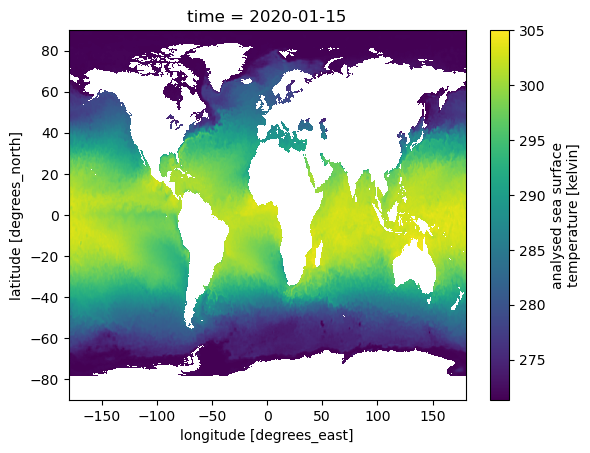

In [9]:
ds['analysed_sst'].plot();

## Conclusion

This concludes tutorial 1. You have worked with remote-sensing data in the cloud and plotted a single file. 

Next we will learn to subset the data so we can work with bigger datasets in the cloud without downloading the whole dataset.

---

## Resources  

- NASA’s [Common Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html)   
- [`earthaccess` repository](https://github.com/nsidc/earthaccess)
- [`earthaccess` documentation](https://nsidc.github.io/earthaccess/)
- [Earthdata Search](https://search.earthdata.nasa.gov/search)